# Rating Prediction – Task 1

This notebook explores using Google's Gemini models to predict ratings from a Kaggle dataset. We will load and sample the data, design multiple prompt variants, parse structured JSON responses, and build an evaluation harness to compare performance and reliability across prompt versions.


## 1) Setup


In [1]:
# ============================================================
# CONFIGURATION - Edit these values as needed
# ============================================================

# Evaluation provider: "openrouter" (recommended for bulk eval) or "gemini"
EVAL_PROVIDER = "openrouter"

# Model to use for evaluation
EVAL_MODEL = "qwen/qwen-2.5-7b-instruct"

# Sample size for stratified sampling
SAMPLE_SIZE = 200

# Random state for reproducibility
RANDOM_STATE = 42

# Evaluation limit: set to None for full eval, or an int (e.g., 20) for quick smoke test
EVAL_LIMIT = None  # Set to 20 for quick mode, None for full 200-row evaluation

print("="*60)
print("TASK 1 CONFIGURATION")
print("="*60)
print(f"  EVAL_PROVIDER : {EVAL_PROVIDER}")
print(f"  EVAL_MODEL    : {EVAL_MODEL}")
print(f"  SAMPLE_SIZE   : {SAMPLE_SIZE}")
print(f"  EVAL_LIMIT    : {EVAL_LIMIT or 'Full (all rows)'}")
print(f"  RANDOM_STATE  : {RANDOM_STATE}")
print("="*60)


TASK 1 CONFIGURATION
  EVAL_PROVIDER : openrouter
  EVAL_MODEL    : qwen/qwen-2.5-7b-instruct
  SAMPLE_SIZE   : 200
  EVAL_LIMIT    : Full (all rows)
  RANDOM_STATE  : 42


In [2]:
# Environment validation
import sys
import os
from dotenv import load_dotenv

load_dotenv()

print(f"Python version: {sys.version}")
print(f"Working directory: {os.getcwd()}")
print()

# Validate required API keys based on provider
if EVAL_PROVIDER == "openrouter":
    OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
    if not OPENROUTER_API_KEY:
        raise ValueError(
            "OPENROUTER_API_KEY is required when EVAL_PROVIDER='openrouter'.\n"
            "Set it in your shell: export OPENROUTER_API_KEY=your_key\n"
            "Or create a .env file in task1/ with: OPENROUTER_API_KEY=your_key"
        )
    print("✓ OPENROUTER_API_KEY found")
    
elif EVAL_PROVIDER == "gemini":
    GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
    if not GOOGLE_API_KEY:
        raise ValueError(
            "GOOGLE_API_KEY is required when EVAL_PROVIDER='gemini'.\n"
            "Set it in your shell: export GOOGLE_API_KEY=your_key\n"
            "Or create a .env file in task1/ with: GOOGLE_API_KEY=your_key"
        )
    print("✓ GOOGLE_API_KEY found")
    
else:
    raise ValueError(f"Unknown EVAL_PROVIDER: {EVAL_PROVIDER}. Use 'openrouter' or 'gemini'.")

# Also check for Gemini key (needed for repair_to_json and some utilities)
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
if GOOGLE_API_KEY:
    print("✓ GOOGLE_API_KEY found (for Gemini utilities)")
else:
    print("⚠ GOOGLE_API_KEY not set (Gemini features disabled)")

print()
print("Environment validation complete. Ready to proceed.")



Python version: 3.11.7 (main, Dec  4 2023, 18:10:11) [Clang 15.0.0 (clang-1500.1.0.2.5)]
Working directory: /Users/kmanoj/fynd-assessment/task1

✓ OPENROUTER_API_KEY found
✓ GOOGLE_API_KEY found (for Gemini utilities)

Environment validation complete. Ready to proceed.


## 2) Data loading + sampling (~200 rows)


In [3]:
import pandas as pd
import numpy as np

# Path to the dataset (user can change filename if needed)
CSV_PATH = "../data/yelp.csv"  # TODO: user can change filename

# 1) Load CSV
df = pd.read_csv(CSV_PATH)

# 2) Detect review text and stars columns (case-insensitive search)
text_candidates = ["text", "review", "review_text", "content", "comments", "Review", "Text"]
stars_candidates = ["stars", "rating", "score", "label", "yelp_rating", "Stars", "Rating"]

lower_to_original = {col.lower(): col for col in df.columns}

text_col = None
for cand in text_candidates:
    col = lower_to_original.get(cand.lower())
    if col is not None:
        text_col = col
        break

stars_col = None
for cand in stars_candidates:
    col = lower_to_original.get(cand.lower())
    if col is not None:
        stars_col = col
        break

if text_col is None:
    raise ValueError(f"Could not detect a text column. Checked candidates: {text_candidates}. Available columns: {list(df.columns)}")

if stars_col is None:
    raise ValueError(f"Could not detect a stars/rating column. Checked candidates: {stars_candidates}. Available columns: {list(df.columns)}")

# 3) Rename detected columns to standardized names
if text_col != "text":
    df = df.rename(columns={text_col: "text"})
if stars_col != "stars":
    df = df.rename(columns={stars_col: "stars"})

# 4) Clean data
# Drop rows where text is missing or empty after stripping
df = df.dropna(subset=["text"])  # ensure we have non-null text

df["text"] = df["text"].astype(str).str.strip()

df = df[df["text"] != ""]

# Convert stars to int and keep only values in [1, 2, 3, 4, 5]
# First, coerce to numeric
stars_numeric = pd.to_numeric(df["stars"], errors="coerce")

# Keep only valid integer ratings in the desired range
valid_mask = stars_numeric.isin([1, 2, 3, 4, 5])

df = df[valid_mask].copy()

df["stars"] = stars_numeric[valid_mask].astype(int)

# Add text length column
df["text_len"] = df["text"].str.len()

# 5) Create deterministic sample dataframe
# Uses SAMPLE_SIZE and RANDOM_STATE from config cell
TARGET_SIZE = SAMPLE_SIZE  # from config

if len(df) < TARGET_SIZE:
    raise ValueError(f"Not enough rows after cleaning to create a {TARGET_SIZE}-row sample. Cleaned rows: {len(df)}")

# Prefer stratified sampling by stars (aim for balance across 1-5)
per_class_target = TARGET_SIZE // 5  # 40 each if all five star levels are present

sample_parts = []
used_indices = set()

for star_value in range(1, 6):
    group = df[df["stars"] == star_value]
    if len(group) == 0:
        continue
    n_take = min(per_class_target, len(group))
    if n_take > 0:
        part = group.sample(n=n_take, random_state=RANDOM_STATE + star_value)
        sample_parts.append(part)
        used_indices.update(part.index.tolist())

if sample_parts:
    df_sample = pd.concat(sample_parts, axis=0)
else:
    # Fallback: if for some reason no star buckets were sampled, draw purely random sample
    df_sample = df.sample(n=TARGET_SIZE, random_state=RANDOM_STATE)

current_size = len(df_sample)

if current_size < TARGET_SIZE:
    remaining = TARGET_SIZE - current_size
    remaining_pool = df.drop(index=df_sample.index, errors="ignore")
    if len(remaining_pool) < remaining:
        raise ValueError(
            f"Not enough remaining rows to top up sample to {TARGET_SIZE}. "
            f"Current sample size: {current_size}, remaining pool: {len(remaining_pool)}"
        )
    top_up = remaining_pool.sample(n=remaining, random_state=RANDOM_STATE)
    df_sample = pd.concat([df_sample, top_up], axis=0)

# Ensure deterministic row order (optional but nice for reproducibility)
df_sample = df_sample.sample(frac=1.0, random_state=RANDOM_STATE).reset_index(drop=True)

# 6) Print diagnostics
print(f"Cleaned dataset shape: {df.shape}")
print("\nStars distribution in df_sample:")
print(df_sample["stars"].value_counts().sort_index())

print("\ntext_len summary (min/median/max):")
text_len_series = df_sample["text_len"]
print(
    "min=", int(text_len_series.min()),
    "median=", float(text_len_series.median()),
    "max=", int(text_len_series.max()),
)

print("\nSample rows (first 3):")
print(df_sample[["stars", "text_len", "text"]].head(3))

# 7) Final assertion
assert len(df_sample) == TARGET_SIZE


Cleaned dataset shape: (10000, 11)

Stars distribution in df_sample:
stars
1    40
2    40
3    40
4    40
5    40
Name: count, dtype: int64

text_len summary (min/median/max):
min= 10 median= 599.0 max= 4960

Sample rows (first 3):
   stars  text_len                                               text
0      3       524  I can understand why everyone loves this place...
1      1      1236  I have been to a buffet like this before, but ...
2      1       643  I've been boycotting this store since 2009.  O...


## 3) Gemini client + JSON parsing utilities


In [4]:
import os
import json
import re
import time
import random

from dotenv import load_dotenv
from google import genai

# --- A) Environment + Gemini setup ---

# Optionally load variables from a .env file in the current directory
load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
if not GOOGLE_API_KEY:
    raise ValueError(
        "GOOGLE_API_KEY is not set. Set it in your shell (export GOOGLE_API_KEY=...) "
        "or create a .env file with GOOGLE_API_KEY=YOUR_KEY in the task1 directory."
    )

client = genai.Client(api_key=GOOGLE_API_KEY)


# --- B) Gemini call wrapper ---

def call_gemini(
    model_name: str,
    prompt: str,
    temperature: float = 0.2,
    max_output_tokens: int = 512,
) -> str:
    """Call a Gemini model with basic retry + exponential backoff.

    Returns the response text.
    """

    generation_config = {
        "temperature": temperature,
        "max_output_tokens": max_output_tokens,
    }

    last_exc: Exception | None = None
    for attempt in range(3):
        try:
            response = client.models.generate_content(
                model=model_name,
                contents=prompt,
                config=generation_config,
            )

            # Prefer response.text when available
            text = getattr(response, "text", None)

            # Fallback: join text parts from candidates/contents
            if text is None:
                parts: list[str] = []

                # Newer google.genai responses expose "candidates" with "content.parts"
                for cand in getattr(response, "candidates", []) or []:
                    content = getattr(cand, "content", None)
                    for p in getattr(content, "parts", []) or []:
                        if getattr(p, "text", None):
                            parts.append(p.text)

                # Also check top-level "content" if present
                top_content = getattr(response, "content", None)
                for p in getattr(top_content, "parts", []) or []:
                    if getattr(p, "text", None):
                        parts.append(p.text)

                if parts:
                    text = "\n".join(parts)

            if not text:
                raise RuntimeError("Gemini response did not contain any text content.")

            return text
        except Exception as exc:  # noqa: BLE001
            last_exc = exc
            # Exponential backoff with jitter: 1-1.5s, 2-2.5s, 4-4.5s
            sleep_seconds = (2**attempt) + random.uniform(0.0, 0.5)
            time.sleep(sleep_seconds)

    raise RuntimeError(f"Gemini call failed after retries: {last_exc}")


# --- C) Robust JSON extraction ---

def extract_first_json(raw: str):
    """Attempt to extract the first JSON object from a raw model string.

    Returns (obj, ok, error).
    """
    if raw is None:
        return None, False, "raw response is None"

    if isinstance(raw, str):
        text = raw.strip()
    else:
        return None, False, "raw response is not a string"

    if not text:
        return None, False, "raw response is empty"

    # Strip code fences ```json ... ``` or ``` ... ```
    # Handle cases like ```json\n{...}\n``` or ```\n{...}\n```.
    fence_pattern = r"^```(?:json)?\s*(.*?)\s*```$"
    m = re.match(fence_pattern, text, flags=re.DOTALL | re.IGNORECASE)
    if m:
        text = m.group(1).strip()

    # First, try straightforward json.loads
    try:
        obj = json.loads(text)
        if isinstance(obj, dict):
            return obj, True, None
        else:
            return None, False, "top-level JSON is not an object (dict)"
    except Exception as e1:  # noqa: BLE001
        # Fallback: regex search for first {...} block
        try:
            brace_pattern = r"\{[\s\S]*?\}"
            m2 = re.search(brace_pattern, text, flags=re.DOTALL)
            if not m2:
                return None, False, f"could not find JSON object braces: {e1}"
            candidate = m2.group(0)
            obj = json.loads(candidate)
            if isinstance(obj, dict):
                return obj, True, None
            else:
                return None, False, "extracted JSON is not an object (dict)"
        except Exception as e2:  # noqa: BLE001
            return None, False, f"failed to parse JSON: primary={e1}, fallback={e2}"


# --- D) Schema validation + prediction function ---

def validate_prediction(obj: dict):
    """Validate prediction schema.

    Expected keys:
      - predicted_stars: int in [1..5]
      - explanation: string (optional, default "")

    Returns (pred, explanation, ok, error).
    """
    if not isinstance(obj, dict):
        return None, None, False, "prediction object is not a dict"

    # Validate predicted_stars
    if "predicted_stars" not in obj:
        return None, None, False, "missing 'predicted_stars' key"

    pred_raw = obj["predicted_stars"]
    try:
        pred_int = int(pred_raw)
    except Exception:  # noqa: BLE001
        return None, None, False, "'predicted_stars' is not an int or int-like"

    if pred_int < 1 or pred_int > 5:
        return None, None, False, "'predicted_stars' is outside allowed range [1..5]"

    # Validate explanation
    explanation = obj.get("explanation", "")
    if explanation is None:
        explanation = ""
    if not isinstance(explanation, str):
        explanation = str(explanation)

    # Truncate explanation to <= 300 chars
    if len(explanation) > 300:
        explanation = explanation[:300]

    return pred_int, explanation, True, None


def repair_to_json(model_name: str, raw: str) -> dict | None:
    """Attempt to repair a malformed or truncated JSON-like model output.

    Uses the model itself to complete/fix the JSON into the expected schema.
    Returns a result dict shaped like predict_one's output, or None if no repair is attempted.
    """
    if raw is None:
        return None

    if not isinstance(raw, str):
        raw_text = str(raw)
    else:
        raw_text = raw.strip()

    if not raw_text:
        return None

    repair_prompt = (
        "You are a strict JSON repair assistant.\n\n"
        "Task:\n"
        "You are given a raw model output that was supposed to be a JSON object for a rating prediction, "
        "but it may be truncated, malformed, or contain extra text.\n\n"
        "Your job:\n"
        "- Read the raw text.\n"
        "- Infer or complete the intended JSON object if possible.\n"
        "- Output ONLY a single valid JSON object with this exact schema:\n"
        "  {\"predicted_stars\": <int 1-5>, \"explanation\": \"<brief reasoning>\"}\n"
        "- Do NOT include markdown, backticks, code fences, or any extra text.\n\n"
        "Raw model output:\n"
        f"{raw_text}\n"
    )

    repaired_raw = None
    try:
        repaired_raw = call_gemini(model_name=model_name, prompt=repair_prompt)
    except Exception as exc:  # noqa: BLE001
        return {
            "raw": repaired_raw,
            "is_valid_json": 0,
            "schema_ok": 0,
            "predicted_stars": None,
            "explanation": None,
            "error": f"repair Gemini call failed: {exc}",
        }

    obj, ok_json, err_json = extract_first_json(repaired_raw)
    is_valid_json = 1 if ok_json else 0
    schema_ok = 0
    predicted_stars = None
    explanation = None
    error_msg = None

    if not ok_json:
        error_msg = f"repair JSON parse error: {err_json}"
    else:
        pred, expl, ok_schema, err_schema = validate_prediction(obj)
        if ok_schema:
            schema_ok = 1
            predicted_stars = pred
            explanation = expl
        else:
            error_msg = f"repair schema validation error: {err_schema}"

    return {
        "raw": repaired_raw,
        "is_valid_json": is_valid_json,
        "schema_ok": schema_ok,
        "predicted_stars": predicted_stars,
        "explanation": explanation,
        "error": error_msg,
    }


def predict_one(model_name: str, prompt_template: str, review_text: str) -> dict:
    """Run a single prediction given a prompt template and review text.

    The template should contain the placeholder {{REVIEW_TEXT}}.
    Returns a dict with keys:
      ['raw', 'is_valid_json', 'schema_ok', 'predicted_stars', 'explanation', 'error']
    """
    if "{{REVIEW_TEXT}}" not in prompt_template:
        raise ValueError("prompt_template must contain the placeholder {{REVIEW_TEXT}}");

    filled_prompt = prompt_template.replace("{{REVIEW_TEXT}}", review_text)

    raw = None
    obj = None
    is_valid_json = 0
    schema_ok = 0
    predicted_stars = None
    explanation = None
    error_msg = None

    try:
        raw = call_gemini(model_name=model_name, prompt=filled_prompt)
    except Exception as exc:  # noqa: BLE001
        error_msg = f"Gemini call failed: {exc}"
        return {
            "raw": raw,
            "is_valid_json": is_valid_json,
            "schema_ok": schema_ok,
            "predicted_stars": predicted_stars,
            "explanation": explanation,
            "error": error_msg,
        }

    # First attempt: direct parse + validation
    obj, ok_json, err_json = extract_first_json(raw)
    if ok_json:
        is_valid_json = 1
    else:
        error_msg = f"JSON parse error: {err_json}"

    if ok_json:
        pred, expl, ok_schema, err_schema = validate_prediction(obj)
        if ok_schema:
            schema_ok = 1
            predicted_stars = pred
            explanation = expl
        else:
            error_msg = f"Schema validation error: {err_schema}"

    # If initial attempt failed (either JSON or schema), try a single repair pass
    if not (is_valid_json and schema_ok):
        repaired = repair_to_json(model_name=model_name, raw=raw)
        if repaired is not None and repaired.get("is_valid_json") and repaired.get("schema_ok"):
            return repaired

    return {
        "raw": raw,
        "is_valid_json": is_valid_json,
        "schema_ok": schema_ok,
        "predicted_stars": predicted_stars,
        "explanation": explanation,
        "error": error_msg,
    }

def predict_one_llm(provider: str, model_name: str, prompt_template: str, review_text: str) -> dict:
       """Unified prediction entrypoint for Gemini and (optionally) OpenRouter.

       provider: "gemini" or "openrouter".
       Returns a dict with keys:
         ["raw","is_valid_json","schema_ok","predicted_stars","explanation","error","provider","model"]
       """
       provider = provider.lower()
       if provider not in {"gemini", "openrouter"}:
           raise ValueError("provider must be 'gemini' or 'openrouter'")

       if "{{REVIEW_TEXT}}" not in prompt_template:
           raise ValueError("prompt_template must contain the placeholder {{REVIEW_TEXT}}")

       filled_prompt = prompt_template.replace("{{REVIEW_TEXT}}", review_text)

       raw = None
       is_valid_json = 0
       schema_ok = 0
       predicted_stars = None
       explanation = None
       error_msg = None

       # 1) Call the appropriate backend
       try:
           if provider == "gemini":
               raw = call_gemini(model_name=model_name, prompt=filled_prompt)
           else:
               # This assumes you have call_openrouter defined; if not, this branch will error.
               raw = call_openrouter(model_name=model_name, prompt=filled_prompt)
       except Exception as exc:  # noqa: BLE001
           error_msg = f"{provider} call failed: {exc}"
           return {
               "raw": raw,
               "is_valid_json": is_valid_json,
               "schema_ok": schema_ok,
               "predicted_stars": predicted_stars,
               "explanation": explanation,
               "error": error_msg,
               "provider": provider,
               "model": model_name,
           }

       # 2) Parse + validate JSON
       obj, ok_json, err_json = extract_first_json(raw)
       if ok_json:
           is_valid_json = 1
       else:
           error_msg = f"JSON parse error: {err_json}"

       if ok_json:
           pred, expl, ok_schema, err_schema = validate_prediction(obj)
           if ok_schema:
               schema_ok = 1
               predicted_stars = pred
               explanation = expl
           else:
               error_msg = f"Schema validation error: {err_schema}"

       # 3) Optional repair for Gemini only
       if provider == "gemini" and not (is_valid_json and schema_ok):
           repaired = repair_to_json(model_name=model_name, raw=raw)
           if repaired is not None and repaired.get("is_valid_json") and repaired.get("schema_ok"):
               repaired["provider"] = provider
               repaired["model"] = model_name
               return repaired

       return {
           "raw": raw,
           "is_valid_json": is_valid_json,
           "schema_ok": schema_ok,
           "predicted_stars": predicted_stars,
           "explanation": explanation,
           "error": error_msg,
           "provider": provider,
           "model": model_name,
       }




In [5]:
# --- E) Tiny smoke test ---

model_name = "gemini-2.5-flash"

# Very simple prompt template: later cells will harden this to enforce strict JSON.
prompt_template = (
    "You are a rating model. Read the following review and respond ONLY with a JSON object "
    "of the form {\"predicted_stars\": int, \"explanation\": string}. The rating must be an integer 1-5.\n\n"
    "Review: {{REVIEW_TEXT}}"
)

example_review = "Amazing service and great food, will come back!"

result = predict_one(model_name=model_name, prompt_template=prompt_template, review_text=example_review)
print(result)



{'raw': '```json\n{\n  "predicted_stars": 5,\n  "explanation": "The review explicitly states \'Amazing service and great food\' and a strong intent to return (\'will come back!\'), indicating a highly positive experience and complete satisfaction."\n}\n```', 'is_valid_json': 1, 'schema_ok': 1, 'predicted_stars': 5, 'explanation': "The review explicitly states 'Amazing service and great food' and a strong intent to return ('will come back!'), indicating a highly positive experience and complete satisfaction.", 'error': None}


## 4) Prompt v1 (baseline)


### Prompt V1 - Baseline

- **Minimal instruction**: Ask the model to act as a strict rating classifier for Yelp reviews.
- **Strict JSON schema**: Require a single JSON object with exactly the keys `"predicted_stars"` and `"explanation"`.
- **Brief explanation**: Keep the explanation short (maximum 1-2 sentences of reasoning for the chosen rating).
- **No markdown / code fences**: Explicitly forbid markdown, backticks, code fences, or any extra commentary outside the JSON object.


In [6]:
PROMPT_V1 = """
You are a strict rating classifier.

Task:
Given a Yelp review, predict the star rating as an integer from 1 to 5.

Output rules (critical):
- Return ONLY a single valid JSON object.
- Do NOT include markdown, code fences, backticks, or any extra text.
- Use EXACTLY these keys: "predicted_stars" and "explanation".
- "predicted_stars" must be an integer 1, 2, 3, 4, or 5.
- "explanation" must be brief (max 2 sentences).

JSON schema:
{"predicted_stars": <int 1-5>, "explanation": "<brief reasoning>"}

Review:
{{REVIEW_TEXT}}
""".strip()



In [7]:
# Test PROMPT_V1 on the first 3 sampled reviews

model_name = "gemini-2.5-flash"

if "df_sample" not in globals():
    raise RuntimeError("df_sample is not defined. Run the data loading + sampling cell first.")

for i in range(3):
    review_text = df_sample.loc[i, "text"]
    result = predict_one(model_name=model_name, prompt_template=PROMPT_V1, review_text=review_text)
    has_fence = "```" in (result.get("raw") or "")

    print(f"--- Example {i} ---")
    print(result)
    print("has_fence:", has_fence)
    print()



--- Example 0 ---
{'raw': '{"predicted_stars": 1, "explanation": "The review indicates a significant decline in quality, describing the gelato as grainy with ice crystals and artificial-tasting flavors. This reflects a very poor experience."}', 'is_valid_json': 1, 'schema_ok': 1, 'predicted_stars': 1, 'explanation': 'The review indicates a significant decline in quality, describing the gelato as grainy with ice crystals and artificial-tasting flavors. This reflects a very poor experience.', 'error': None}
has_fence: False

--- Example 1 ---
{'raw': '{"predicted_stars": 1, "explanation": "The review is overwhelmingly negative, citing disgusting soup, bland ingredients, potentially spoiled tofu, and fowl-tasting meat, leading the diners to leave without finishing. The strong recommendation against returning justifies the lowest possible rating."}', 'is_valid_json': 1, 'schema_ok': 1, 'predicted_stars': 1, 'explanation': 'The review is overwhelmingly negative, citing disgusting soup, blan

In [8]:
# Robustness test for PROMPT_V1 with repair logic

model_name = "gemini-2.5-flash"

if "df_sample" not in globals():
    raise RuntimeError("df_sample is not defined. Run the data loading + sampling cell first.")

for i in range(3):
    review_text = df_sample.loc[i, "text"]
    result = predict_one(model_name=model_name, prompt_template=PROMPT_V1, review_text=review_text)

    print(f"--- Robust Example {i} ---")
    print("is_valid_json:", result.get("is_valid_json"), "schema_ok:", result.get("schema_ok"))
    print(result)
    print()



--- Robust Example 0 ---
is_valid_json: 1 schema_ok: 1
{'raw': '{"predicted_stars": 2, "explanation": "The review indicates a significant decline in quality."}', 'is_valid_json': 1, 'schema_ok': 1, 'predicted_stars': 2, 'explanation': 'The review indicates a significant decline in quality.', 'error': None}

--- Robust Example 1 ---
is_valid_json: 0 schema_ok: 0
{'raw': None, 'is_valid_json': 0, 'schema_ok': 0, 'predicted_stars': None, 'explanation': None, 'error': "Gemini call failed: Gemini call failed after retries: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \\n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash\\nPlease retry in 12.06770484

## 5) Prompt v2 (rubric + JSON hardening)


### Prompt V2 - Rubric + Hard Constraints

- Explicit star-rating rubric: Adds a compact 1-5 star rubric to reduce ambiguity in how borderline reviews are scored.
- Stricter JSON-only output: Reinforces that the model must return only a single JSON object with the expected keys and no markdown or code fences.
- Better mid-range handling: Designed to improve accuracy and consistency on mixed or borderline reviews (especially 2★/3★/4★).

In [9]:
PROMPT_V2 = """
You are a strict Yelp star rating classifier.

Task:
Given a Yelp review, predict the star rating as an integer from 1 to 5.

Star rubric (use this to decide):
- 1★: Extremely negative. Severe problems, anger, “never again”, “avoid”.
- 2★: Mostly negative. Multiple issues outweigh positives; dissatisfaction is clear.
- 3★: Mixed or average. Neutral/okay; pros and cons balance; “fine”, “meh”.
- 4★: Mostly positive. Minor issues but overall satisfied; would return/recommend.
- 5★: Extremely positive. Outstanding experience; strong praise; highly recommend.

Decision rule for mixed sentiment:
- If clearly leaning positive → 4★
- If clearly leaning negative → 2★
- Otherwise → 3★

Output rules (critical):
- Return ONLY a single valid JSON object.
- Do NOT include markdown, code fences, backticks, or any extra text.
- Use EXACTLY these keys: "predicted_stars" and "explanation".
- "predicted_stars" must be an integer 1..5.
- "explanation" must be brief (max 2 sentences).

JSON schema:
{"predicted_stars": <int 1-5>, "explanation": "<brief reasoning>"}

Review:
{{REVIEW_TEXT}}
""".strip()



In [10]:
# Prompt V2 test on ambiguous mid-range reviews

model_name = "gemini-2.5-flash"

if "df_sample" not in globals():
    raise RuntimeError("df_sample is not defined. Run the data loading + sampling cell first.")

# a) 3 random rows where true stars == 3
three_star_rows = df_sample[df_sample["stars"] == 3].sample(n=3, random_state=42)

# b) 3 random rows where true stars == 4
four_star_rows = df_sample[df_sample["stars"] == 4].sample(n=3, random_state=42)

print("=== 3-star reviews (true label = 3) ===")
for idx, row in three_star_rows.iterrows():
    review_text = row["text"]
    true_stars = row["stars"]
    result = predict_one(model_name=model_name, prompt_template=PROMPT_V2, review_text=review_text)

    print(f"--- idx={idx}, true_stars={true_stars} ---")
    print(result)
    print()

print("\n=== 4-star reviews (true label = 4) ===")
for idx, row in four_star_rows.iterrows():
    review_text = row["text"]
    true_stars = row["stars"]
    result = predict_one(model_name=model_name, prompt_template=PROMPT_V2, review_text=review_text)

    print(f"--- idx={idx}, true_stars={true_stars} ---")
    print(result)
    print()



=== 3-star reviews (true label = 3) ===
--- idx=92, true_stars=3 ---
{'raw': None, 'is_valid_json': 0, 'schema_ok': 0, 'predicted_stars': None, 'explanation': None, 'error': "Gemini call failed: Gemini call failed after retries: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \\n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash\\nPlease retry in 55.785877368s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations'

In [11]:
# OpenRouter client setup (standalone cell for reliability)

import os
import time
import random
import requests

OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
if not OPENROUTER_API_KEY:
    raise ValueError("OPENROUTER_API_KEY not found. Add it to task1/.env or export it in your shell.")

def call_openrouter(
    model_name: str,
    prompt: str,
    temperature: float = 0.2,
    max_tokens: int = 256,
    max_retries: int = 3,
) -> str:
    """Call an OpenRouter chat model with retry + backoff."""
    url = "https://openrouter.ai/api/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {OPENROUTER_API_KEY}",
        "Content-Type": "application/json",
    }
    payload = {
        "model": model_name,
        "messages": [{"role": "user", "content": prompt}],
        "temperature": temperature,
        "max_tokens": max_tokens,
    }

    last_err = None
    for attempt in range(max_retries):
        try:
            resp = requests.post(url, headers=headers, json=payload, timeout=60)
            if resp.status_code != 200:
                raise RuntimeError(f"OpenRouter HTTP {resp.status_code}: {resp.text[:500]}")
            data = resp.json()
            return data["choices"][0]["message"]["content"]
        except Exception as e:
            last_err = e
            time.sleep((2 ** attempt) + random.uniform(0, 0.5))
    raise RuntimeError(f"OpenRouter call failed after retries: {last_err}")

print("call_openrouter defined:", "call_openrouter" in dir())



call_openrouter defined: True


In [12]:
# Quick sanity check: Prompt V2 on OpenRouter (10 rows)

provider = "openrouter"
model_name = "qwen/qwen-2.5-7b-instruct"

if "df_sample" not in globals():
    raise RuntimeError("df_sample is not defined. Run the data loading + sampling cell first.")

if "PROMPT_V2" not in globals():
    raise RuntimeError("PROMPT_V2 is not defined. Run the Prompt V2 cell first.")

# Sample 5 rows where stars==3, 5 rows where stars==4
three_star_sample = df_sample[df_sample["stars"] == 3].sample(n=5, random_state=42)
four_star_sample = df_sample[df_sample["stars"] == 4].sample(n=5, random_state=42)

test_rows = pd.concat([three_star_sample, four_star_sample])

results = []

print("=== Prompt V2 on OpenRouter (10-row sanity check) ===\n")

for idx, row in test_rows.iterrows():
    review_text = row["text"]
    true_stars = row["stars"]
    
    result = predict_one_llm(
        provider=provider,
        model_name=model_name,
        prompt_template=PROMPT_V2,
        review_text=review_text,
    )
    
    pred_stars = result.get("predicted_stars")
    schema_ok = result.get("schema_ok")
    explanation = (result.get("explanation") or "")[:60] + "..." if result.get("explanation") else "N/A"
    
    results.append({
        "idx": idx,
        "true_stars": true_stars,
        "predicted_stars": pred_stars,
        "schema_ok": schema_ok,
    })
    
    print(f"idx={idx:3} | true={true_stars} | pred={pred_stars} | schema_ok={schema_ok} | expl: {explanation}")

print("\n" + "="*60)

# Summary stats
schema_ok_count = sum(1 for r in results if r["schema_ok"] == 1)
schema_ok_rate = schema_ok_count / len(results)

# Exact match accuracy (only where schema_ok==1)
valid_results = [r for r in results if r["schema_ok"] == 1]
if valid_results:
    exact_matches = sum(1 for r in valid_results if r["true_stars"] == r["predicted_stars"])
    accuracy = exact_matches / len(valid_results)
else:
    accuracy = 0.0

print(f"\nschema_ok rate: {schema_ok_rate:.1%} ({schema_ok_count}/{len(results)})")
print(f"exact-match accuracy (where schema_ok=1): {accuracy:.1%} ({exact_matches if valid_results else 0}/{len(valid_results)})")



=== Prompt V2 on OpenRouter (10-row sanity check) ===

idx= 92 | true=3 | pred=3 | schema_ok=1 | expl: Mixed sentiments with more neutral to positive points, but a...
idx= 78 | true=3 | pred=3 | schema_ok=1 | expl: The review contains both positive and negative points, with ...
idx= 75 | true=3 | pred=2 | schema_ok=1 | expl: The review highlights significant service issues and frustra...
idx=144 | true=3 | pred=4 | schema_ok=1 | expl: The review highlights several positive aspects such as the a...
idx= 26 | true=3 | pred=3 | schema_ok=1 | expl: The review has both positive and negative points, with no st...
idx= 99 | true=4 | pred=4 | schema_ok=1 | expl: The review is predominantly positive with praise for the foo...
idx= 77 | true=4 | pred=4 | schema_ok=1 | expl: The review highlights several positive aspects like fresh hu...
idx= 71 | true=4 | pred=4 | schema_ok=1 | expl: The review mentions both positive and negative aspects, but ...
idx=122 | true=4 | pred=4 | schema_ok=1 | expl: T

### Prompt V3 - Few-shot + Edge Cases

- **Few-shot examples**: Adds 5 compact examples to calibrate the model on rubric boundaries and common failure modes.
- **Edge case coverage**: Focuses on mixed sentiment ("good food, bad service"), short neutral reviews ("ok", "meh"), and strong praise/complaints.
- **Strict JSON output**: Maintains the same JSON-only formatting rules from V2.
- **Goal**: Improve accuracy on borderline 2★/3★/4★ reviews where V1/V2 may drift.



In [13]:
PROMPT_V3 = """
You are a strict Yelp star rating classifier.

Star rubric:
- 1★: Extremely negative. Severe problems, anger, "never again", "avoid".
- 2★: Mostly negative. Multiple issues outweigh positives; dissatisfaction is clear.
- 3★: Mixed or average. Neutral/okay; pros and cons balance; "fine", "meh".
- 4★: Mostly positive. Minor issues but overall satisfied; would return/recommend.
- 5★: Extremely positive. Outstanding experience; strong praise; highly recommend.

Decision rule for mixed sentiment:
- If clearly leaning positive → 4★
- If clearly leaning negative → 2★
- Otherwise → 3★

Output rules (critical):
- Return ONLY a single valid JSON object.
- Do NOT include markdown, code fences, backticks, or any extra text.
- Use EXACTLY these keys: "predicted_stars" and "explanation".
- "predicted_stars" must be an integer 1..5.
- "explanation" must be brief (max 2 sentences).

Few-shot examples:

Review: "Absolutely fantastic. Friendly staff, delicious food, perfect experience."
Output: {"predicted_stars": 5, "explanation": "Strong praise across service and food with no notable negatives."}

Review: "It was okay. Nothing special, but not bad either."
Output: {"predicted_stars": 3, "explanation": "Neutral/average sentiment with no strong positives or negatives."}

Review: "Food tasted great, but the service was slow and rude. Not sure I'd return."
Output: {"predicted_stars": 3, "explanation": "Clear mix of strong positive (food) and strong negative (service), overall average."}

Review: "Great place overall. Loved the ambience and the meal, just a bit pricey."
Output: {"predicted_stars": 4, "explanation": "Mostly positive experience with a minor complaint."}

Review: "Terrible experience. Cold food, messy tables, and I will never come back."
Output: {"predicted_stars": 1, "explanation": "Severely negative with multiple major complaints and a strong refusal to return."}

Now classify this review.

Review:
{{REVIEW_TEXT}}
""".strip()



In [14]:
# Prompt V3 test on OpenRouter (10 x 3★ reviews)

provider = "openrouter"
model_name = "qwen/qwen-2.5-7b-instruct"

if "df_sample" not in globals():
    raise RuntimeError("df_sample is not defined. Run the data loading + sampling cell first.")

if "PROMPT_V3" not in globals():
    raise RuntimeError("PROMPT_V3 is not defined. Run the PROMPT_V3 cell first.")

# 10 random rows where stars == 3 (the hardest class)
three_star_sample = df_sample[df_sample["stars"] == 3].sample(n=10, random_state=7)

results = []

print("=== Prompt V3 on OpenRouter (10 x 3★ reviews) ===\n")

for idx, row in three_star_sample.iterrows():
    review_text = row["text"]
    true_stars = row["stars"]
    
    result = predict_one_llm(
        provider=provider,
        model_name=model_name,
        prompt_template=PROMPT_V3,
        review_text=review_text,
    )
    
    pred_stars = result.get("predicted_stars")
    schema_ok = result.get("schema_ok")
    explanation = (result.get("explanation") or "")[:50] + "..." if result.get("explanation") else "N/A"
    
    results.append({
        "idx": idx,
        "true_stars": true_stars,
        "predicted_stars": pred_stars,
        "schema_ok": schema_ok,
    })
    
    print(f"idx={idx:3} | true={true_stars} | pred={pred_stars} | schema_ok={schema_ok} | {explanation}")

print("\n" + "="*60)

# Summary stats
schema_ok_count = sum(1 for r in results if r["schema_ok"] == 1)
schema_ok_rate = schema_ok_count / len(results)

# Exact match accuracy (only where schema_ok==1)
valid_results = [r for r in results if r["schema_ok"] == 1]
if valid_results:
    exact_matches = sum(1 for r in valid_results if r["true_stars"] == r["predicted_stars"])
    accuracy = exact_matches / len(valid_results)
else:
    exact_matches = 0
    accuracy = 0.0

print(f"\nschema_ok rate: {schema_ok_rate:.1%} ({schema_ok_count}/{len(results)})")
print(f"exact-match accuracy on 3★ (where schema_ok=1): {accuracy:.1%} ({exact_matches}/{len(valid_results)})")



=== Prompt V3 on OpenRouter (10 x 3★ reviews) ===

idx= 79 | true=3 | pred=2 | schema_ok=1 | Multiple issues with service overshadow the positi...
idx=195 | true=3 | pred=3 | schema_ok=1 | Mixed sentiment with mostly positive aspects but m...
idx=186 | true=3 | pred=3 | schema_ok=1 | Mixed sentiment with a clear issue about the salti...
idx= 85 | true=3 | pred=3 | schema_ok=1 | Initial review leaned negative due to pricing issu...
idx=171 | true=3 | pred=2 | schema_ok=1 | Multiple issues with dental care and communication...
idx=  5 | true=3 | pred=2 | schema_ok=1 | Multiple issues with the dining experience, includ...
idx=121 | true=3 | pred=3 | schema_ok=1 | Mixed sentiment with a focus on the unexpected dem...
idx= 18 | true=3 | pred=4 | schema_ok=1 | Mostly positive experience with a minor complaint ...
idx= 57 | true=3 | pred=4 | schema_ok=1 | Mostly positive experience with a few minor issues...
idx=188 | true=3 | pred=3 | schema_ok=1 | Mixed sentiments with significant negatives

In [15]:
# Full Evaluation: PROMPT_V1, PROMPT_V2, PROMPT_V3

from tqdm import tqdm
import numpy as np

# Use config constants
provider = EVAL_PROVIDER
model_name = EVAL_MODEL

# Ensure prerequisites
if "df_sample" not in globals():
    raise RuntimeError("df_sample is not defined. Run the data loading cell first.")
if "PROMPT_V1" not in globals() or "PROMPT_V2" not in globals() or "PROMPT_V3" not in globals():
    raise RuntimeError("PROMPT_V1/V2/V3 not all defined. Run their definition cells first.")

prompts = {
    "V1": PROMPT_V1,
    "V2": PROMPT_V2,
    "V3": PROMPT_V3,
}

# Determine evaluation subset
if EVAL_LIMIT is not None:
    eval_df = df_sample.head(EVAL_LIMIT).copy()
    print(f"🚀 QUICK MODE: Evaluating first {EVAL_LIMIT} rows only")
else:
    eval_df = df_sample.copy()
    print(f"🔥 FULL MODE: Evaluating all {len(eval_df)} rows")

all_results = []

for prompt_name, prompt_template in prompts.items():
    print(f"\n{'='*60}")
    print(f"Running {prompt_name} on {len(eval_df)} rows (provider={provider})...")
    print(f"{'='*60}")
    
    for idx, row in tqdm(eval_df.iterrows(), total=len(eval_df), desc=prompt_name):
        review_text = row["text"]
        true_stars = row["stars"]
        text_len = row["text_len"]
        
        result = predict_one_llm(
            provider=provider,
            model_name=model_name,
            prompt_template=prompt_template,
            review_text=review_text,
        )
        
        all_results.append({
            "prompt": prompt_name,
            "stars_true": true_stars,
            "stars_pred": result.get("predicted_stars"),
            "schema_ok": result.get("schema_ok"),
            "is_valid_json": result.get("is_valid_json"),
            "text_len": text_len,
            "error": result.get("error"),
        })

# Create results dataframe
df_results = pd.DataFrame(all_results)
print(f"\nTotal predictions: {len(df_results)}")
print(f"Provider: {provider}, Model: {model_name}")



🔥 FULL MODE: Evaluating all 200 rows

Running V1 on 200 rows (provider=openrouter)...


V1: 100%|██████████| 200/200 [03:38<00:00,  1.09s/it]



Running V2 on 200 rows (provider=openrouter)...


V2: 100%|██████████| 200/200 [02:51<00:00,  1.17it/s]



Running V3 on 200 rows (provider=openrouter)...


V3: 100%|██████████| 200/200 [03:38<00:00,  1.09s/it]


Total predictions: 600
Provider: openrouter, Model: qwen/qwen-2.5-7b-instruct


In [16]:
# Compute metrics per prompt version

def compute_metrics(df, prompt_name):
    """Compute evaluation metrics for a single prompt version."""
    subset = df[df["prompt"] == prompt_name].copy()
    n_total = len(subset)
    
    n_schema_ok = subset["schema_ok"].sum()
    n_valid_json = subset["is_valid_json"].sum()
    schema_ok_rate = n_schema_ok / n_total if n_total > 0 else 0
    json_valid_rate = n_valid_json / n_total if n_total > 0 else 0
    coverage = schema_ok_rate
    
    valid = subset[subset["schema_ok"] == 1].copy()
    n_valid = len(valid)
    
    if n_valid == 0:
        return {
            "prompt": prompt_name, "n_total": n_total, "n_schema_ok": n_schema_ok,
            "coverage": coverage, "json_valid_rate": json_valid_rate,
            "schema_ok_rate": schema_ok_rate, "exact_accuracy": 0.0,
            "off_by_1_accuracy": 0.0, "mae": np.nan,
        }
    
    exact_matches = (valid["stars_pred"] == valid["stars_true"]).sum()
    exact_accuracy = exact_matches / n_valid
    off_by_1 = (abs(valid["stars_pred"] - valid["stars_true"]) <= 1).sum()
    off_by_1_accuracy = off_by_1 / n_valid
    mae = abs(valid["stars_pred"] - valid["stars_true"]).mean()
    
    return {
        "prompt": prompt_name, "n_total": n_total, "n_schema_ok": n_schema_ok,
        "coverage": coverage, "json_valid_rate": json_valid_rate,
        "schema_ok_rate": schema_ok_rate, "exact_accuracy": exact_accuracy,
        "off_by_1_accuracy": off_by_1_accuracy, "mae": mae,
    }

metrics_list = [compute_metrics(df_results, p) for p in ["V1", "V2", "V3"]]
df_comparison = pd.DataFrame(metrics_list)
df_comparison = df_comparison.sort_values(by=["mae", "off_by_1_accuracy"], ascending=[True, False]).reset_index(drop=True)

# Format for display
df_display = df_comparison.copy()
for col in ["coverage", "json_valid_rate", "schema_ok_rate", "exact_accuracy", "off_by_1_accuracy"]:
    df_display[col] = df_display[col].apply(lambda x: f"{x:.1%}")
df_display["mae"] = df_display["mae"].apply(lambda x: f"{x:.3f}" if not np.isnan(x) else "N/A")

print("\n" + "="*80)
print("EVALUATION RESULTS: Prompt Comparison (sorted by MAE ↑, Off-by-1 ↓)")
print("="*80)
print(df_display.to_string(index=False))
print("="*80)




EVALUATION RESULTS: Prompt Comparison (sorted by MAE ↑, Off-by-1 ↓)
prompt  n_total  n_schema_ok coverage json_valid_rate schema_ok_rate exact_accuracy off_by_1_accuracy   mae
    V2      200          200   100.0%          100.0%         100.0%          68.0%             98.0% 0.355
    V3      200          200   100.0%          100.0%         100.0%          65.0%             98.5% 0.380
    V1      200          200   100.0%          100.0%         100.0%          64.5%             98.0% 0.390


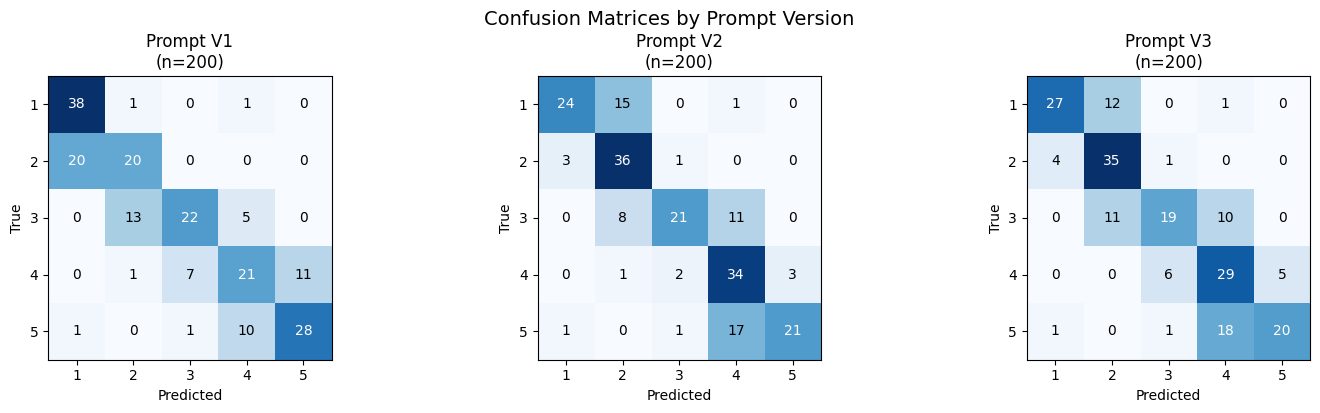


Per-class accuracy (schema_ok rows only):
------------------------------------------------------------
V1: 1★:95% | 2★:50% | 3★:55% | 4★:52% | 5★:70%
V2: 1★:60% | 2★:90% | 3★:52% | 4★:85% | 5★:52%
V3: 1★:68% | 2★:88% | 3★:48% | 4★:72% | 5★:50%


In [17]:
# Confusion matrices per prompt version

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, prompt_name in enumerate(["V1", "V2", "V3"]):
    subset = df_results[(df_results["prompt"] == prompt_name) & (df_results["schema_ok"] == 1)]
    
    if len(subset) == 0:
        axes[i].text(0.5, 0.5, "No valid predictions", ha="center", va="center")
        axes[i].set_title(f"Prompt {prompt_name}")
        continue
    
    y_true = subset["stars_true"].values
    y_pred = subset["stars_pred"].values
    cm = confusion_matrix(y_true, y_pred, labels=[1, 2, 3, 4, 5])
    
    im = axes[i].imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    axes[i].set_title(f"Prompt {prompt_name}\n(n={len(subset)})")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")
    axes[i].set_xticks(range(5))
    axes[i].set_yticks(range(5))
    axes[i].set_xticklabels([1, 2, 3, 4, 5])
    axes[i].set_yticklabels([1, 2, 3, 4, 5])
    
    thresh = cm.max() / 2.0
    for row in range(5):
        for col in range(5):
            axes[i].text(col, row, format(cm[row, col], "d"),
                        ha="center", va="center",
                        color="white" if cm[row, col] > thresh else "black")

plt.tight_layout()
plt.suptitle("Confusion Matrices by Prompt Version", y=1.02, fontsize=14)

# Save figure for later use
confusion_fig = fig
plt.show()

# Per-class accuracy breakdown
print("\nPer-class accuracy (schema_ok rows only):")
print("-" * 60)
per_class_data = []
for prompt_name in ["V1", "V2", "V3"]:
    subset = df_results[(df_results["prompt"] == prompt_name) & (df_results["schema_ok"] == 1)]
    if len(subset) == 0:
        continue
    row_data = {"prompt": prompt_name}
    for star in [1, 2, 3, 4, 5]:
        star_subset = subset[subset["stars_true"] == star]
        if len(star_subset) > 0:
            acc = (star_subset["stars_pred"] == star).mean()
            row_data[f"{star}★"] = f"{acc:.0%}"
        else:
            row_data[f"{star}★"] = "N/A"
    per_class_data.append(row_data)
    print(f"{prompt_name}: " + " | ".join([f"{star}★:{row_data[f'{star}★']}" for star in [1,2,3,4,5]]))

df_per_class = pd.DataFrame(per_class_data)



In [18]:
# Save outputs to disk

import os
from pathlib import Path

# Create outputs directory
output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)

saved_files = []

# 1) Save prompt comparison CSV
comparison_path = output_dir / "prompt_comparison.csv"
df_comparison.to_csv(comparison_path, index=False)
saved_files.append(str(comparison_path))

# 2) Save per-class accuracy CSV
per_class_path = output_dir / "per_class_accuracy.csv"
df_per_class.to_csv(per_class_path, index=False)
saved_files.append(str(per_class_path))

# 3) Save confusion matrices PNG
confusion_path = output_dir / "confusion_matrices.png"
confusion_fig.savefig(confusion_path, dpi=150, bbox_inches="tight")
saved_files.append(str(confusion_path))

# 4) Save full results CSV (for deeper analysis)
full_results_path = output_dir / "full_results.csv"
df_results.to_csv(full_results_path, index=False)
saved_files.append(str(full_results_path))

print("="*60)
print("ARTIFACTS SAVED")
print("="*60)
for f in saved_files:
    print(f"  ✓ {f}")
print("="*60)



ARTIFACTS SAVED
  ✓ outputs/prompt_comparison.csv
  ✓ outputs/per_class_accuracy.csv
  ✓ outputs/confusion_matrices.png
  ✓ outputs/full_results.csv


In [19]:
# Full Evaluation: PROMPT_V1, PROMPT_V2, PROMPT_V3 on all 200 rows (OpenRouter)

from tqdm import tqdm
import numpy as np

provider = "openrouter"
model_name = "qwen/qwen-2.5-7b-instruct"

# Ensure prerequisites
if "df_sample" not in globals():
    raise RuntimeError("df_sample is not defined. Run the data loading cell first.")
if "PROMPT_V1" not in globals() or "PROMPT_V2" not in globals() or "PROMPT_V3" not in globals():
    raise RuntimeError("PROMPT_V1/V2/V3 not all defined. Run their definition cells first.")

prompts = {
    "V1": PROMPT_V1,
    "V2": PROMPT_V2,
    "V3": PROMPT_V3,
}

all_results = []

for prompt_name, prompt_template in prompts.items():
    print(f"\n{'='*60}")
    print(f"Running {prompt_name} on {len(df_sample)} rows...")
    print(f"{'='*60}")
    
    for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample), desc=prompt_name):
        review_text = row["text"]
        true_stars = row["stars"]
        text_len = row["text_len"]
        
        result = predict_one_llm(
            provider=provider,
            model_name=model_name,
            prompt_template=prompt_template,
            review_text=review_text,
        )
        
        all_results.append({
            "prompt": prompt_name,
            "stars_true": true_stars,
            "stars_pred": result.get("predicted_stars"),
            "schema_ok": result.get("schema_ok"),
            "is_valid_json": result.get("is_valid_json"),
            "text_len": text_len,
            "error": result.get("error"),
        })

# Create results dataframe
df_results = pd.DataFrame(all_results)
print(f"\nTotal predictions: {len(df_results)}")




Running V1 on 200 rows...


V1:  34%|███▍      | 68/200 [01:19<02:35,  1.18s/it]


KeyboardInterrupt: 

In [ ]:
# Compute metrics per prompt version

def compute_metrics(df, prompt_name):
    """Compute evaluation metrics for a single prompt version."""
    subset = df[df["prompt"] == prompt_name].copy()
    n_total = len(subset)
    
    # Schema OK / JSON validity
    n_schema_ok = subset["schema_ok"].sum()
    n_valid_json = subset["is_valid_json"].sum()
    schema_ok_rate = n_schema_ok / n_total if n_total > 0 else 0
    json_valid_rate = n_valid_json / n_total if n_total > 0 else 0
    coverage = schema_ok_rate  # same as schema_ok_rate for our purposes
    
    # Filter to schema_ok rows only for accuracy metrics
    valid = subset[subset["schema_ok"] == 1].copy()
    n_valid = len(valid)
    
    if n_valid == 0:
        return {
            "prompt": prompt_name,
            "n_total": n_total,
            "n_schema_ok": n_schema_ok,
            "coverage": coverage,
            "json_valid_rate": json_valid_rate,
            "schema_ok_rate": schema_ok_rate,
            "exact_accuracy": 0.0,
            "off_by_1_accuracy": 0.0,
            "mae": np.nan,
        }
    
    # Exact match accuracy
    exact_matches = (valid["stars_pred"] == valid["stars_true"]).sum()
    exact_accuracy = exact_matches / n_valid
    
    # Off-by-1 accuracy
    off_by_1 = (abs(valid["stars_pred"] - valid["stars_true"]) <= 1).sum()
    off_by_1_accuracy = off_by_1 / n_valid
    
    # MAE
    mae = abs(valid["stars_pred"] - valid["stars_true"]).mean()
    
    return {
        "prompt": prompt_name,
        "n_total": n_total,
        "n_schema_ok": n_schema_ok,
        "coverage": coverage,
        "json_valid_rate": json_valid_rate,
        "schema_ok_rate": schema_ok_rate,
        "exact_accuracy": exact_accuracy,
        "off_by_1_accuracy": off_by_1_accuracy,
        "mae": mae,
    }

# Compute metrics for each prompt
metrics_list = []
for prompt_name in ["V1", "V2", "V3"]:
    metrics = compute_metrics(df_results, prompt_name)
    metrics_list.append(metrics)

# Create comparison dataframe
df_comparison = pd.DataFrame(metrics_list)

# Sort by MAE ascending, then off-by-1 accuracy descending
df_comparison = df_comparison.sort_values(
    by=["mae", "off_by_1_accuracy"],
    ascending=[True, False]
).reset_index(drop=True)

# Format for display
df_display = df_comparison.copy()
df_display["coverage"] = df_display["coverage"].apply(lambda x: f"{x:.1%}")
df_display["json_valid_rate"] = df_display["json_valid_rate"].apply(lambda x: f"{x:.1%}")
df_display["schema_ok_rate"] = df_display["schema_ok_rate"].apply(lambda x: f"{x:.1%}")
df_display["exact_accuracy"] = df_display["exact_accuracy"].apply(lambda x: f"{x:.1%}")
df_display["off_by_1_accuracy"] = df_display["off_by_1_accuracy"].apply(lambda x: f"{x:.1%}")
df_display["mae"] = df_display["mae"].apply(lambda x: f"{x:.3f}" if not np.isnan(x) else "N/A")

print("\n" + "="*80)
print("EVALUATION RESULTS: Prompt Comparison (sorted by MAE ↑, Off-by-1 ↓)")
print("="*80)
print(df_display.to_string(index=False))
print("="*80)



In [ ]:
# Confusion matrices per prompt version

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, prompt_name in enumerate(["V1", "V2", "V3"]):
    subset = df_results[(df_results["prompt"] == prompt_name) & (df_results["schema_ok"] == 1)]
    
    if len(subset) == 0:
        axes[i].text(0.5, 0.5, "No valid predictions", ha="center", va="center")
        axes[i].set_title(f"Prompt {prompt_name}")
        continue
    
    y_true = subset["stars_true"].values
    y_pred = subset["stars_pred"].values
    
    cm = confusion_matrix(y_true, y_pred, labels=[1, 2, 3, 4, 5])
    
    # Plot confusion matrix
    im = axes[i].imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    axes[i].set_title(f"Prompt {prompt_name}\n(n={len(subset)})")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")
    axes[i].set_xticks(range(5))
    axes[i].set_yticks(range(5))
    axes[i].set_xticklabels([1, 2, 3, 4, 5])
    axes[i].set_yticklabels([1, 2, 3, 4, 5])
    
    # Add text annotations
    thresh = cm.max() / 2.0
    for row in range(5):
        for col in range(5):
            axes[i].text(col, row, format(cm[row, col], "d"),
                        ha="center", va="center",
                        color="white" if cm[row, col] > thresh else "black")

plt.tight_layout()
plt.suptitle("Confusion Matrices by Prompt Version", y=1.02, fontsize=14)
plt.show()

# Per-class accuracy breakdown
print("\nPer-class accuracy (schema_ok rows only):")
print("-" * 60)
for prompt_name in ["V1", "V2", "V3"]:
    subset = df_results[(df_results["prompt"] == prompt_name) & (df_results["schema_ok"] == 1)]
    if len(subset) == 0:
        print(f"{prompt_name}: No valid predictions")
        continue
    
    class_acc = []
    for star in [1, 2, 3, 4, 5]:
        star_subset = subset[subset["stars_true"] == star]
        if len(star_subset) > 0:
            acc = (star_subset["stars_pred"] == star).mean()
            class_acc.append(f"{star}★:{acc:.0%}")
        else:
            class_acc.append(f"{star}★:N/A")
    
    print(f"{prompt_name}: {' | '.join(class_acc)}")



## 6) Prompt v3 (few-shot + edge cases)


In [ ]:
# OpenRouter smoke test using PROMPT_V2

provider = "openrouter"
openrouter_model = "qwen/qwen-2.5-7b-instruct"  # can be swapped for another stable instruct model

example_review = "Amazing service and great food, will come back!"

if "PROMPT_V2" not in globals():
    raise RuntimeError("PROMPT_V2 is not defined. Run the Prompt V2 cell first.")

result_openrouter = predict_one_llm(
    provider=provider,
    model_name=openrouter_model,
    prompt_template=PROMPT_V2,
    review_text=example_review,
)

print(result_openrouter)

